# Hades Star TSP Solver

## About

This is a set of calculations, namely involving using a TSP (travelling salesman problem) solver, to optimize station and warp lane placement in Hades Star.

## Stategy involved

The core strategy here is to minimize travel distance for a route to hit ALL planets and stations.  The assumptions here are that:
* We don't want to use auto-shipment drones (they achieve considerably fewer credits than stacked Trade Burst + Shipment Comupter)
* The distribution of target planets can be considered random (and note that this isn't actually the case...as you explore more planets, those higher-yield ones further away are going to collectively generate more shipments to each other)
* We don't want to spend time actually looking at the shipments for each individual planet each time we farm shipments

Once we find the optimal path, best way to use should be to:
1. Fire up warp lanes
2. Trade burst two ships and send them opposite directions around the path (this helps prevent carrying shipments the long way around)

## Steps shown below

1. Initialize planet and sector data that was collected using our *Hades Star Data Builder* workbook.
2. Write a helper for visualizing the data overlayed on our star system screenshot.
3. Write a helper for calculating pairwise distances between planets, also supporting a list of warp lanes where the pairwise distance is considered zero.
4. Test Google's OR tools solver to optimize the bare path (no warp lanes, no trade stations)
5. Calculate the amount of time to optimize over three warp lanes with a brute force approach
6. Conclude the above is too long! **Several hours** and we haven't even placed trade stations.
7. Generate a list of possible trade station points (hexagon center + hexagon corners)
8. Write helpers for adding warp lanes and trade stations to our system map.
9. Come up with a sub-optimal solution by adding, alternatively, one trade station and one warplane, optimizing for each step


## Further Work?!

The approach of adding one station/warp lane at a time is very suboptimal.  Would be much better to add these as additional dimensions in the solver and optimize across the board simultaneously.

In [51]:
# initialize
import pandas as pd
import numpy as np
import itertools as itertools
from ipywidgets import Image, widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plot
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import math
import re

# two column, but don't let our images get squished;
# stop line-breaking in the middle on numbers (Jupyter bug?);
# blend our star system images left into the graphs beside them
CSS = """
.output {
    flex-direction: row;
}
div.output_subarea, div.output_area img {
  max-width: none;
}
.widget-image {
    position: absolute !important;
    left: 125px !important;
    top: 15px !important;
    opacity: 0.2 !important;
    width: 392px !important;
    height: 705px !important;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [52]:
# Helpers for overlaying an image on our plots
def configure_planet_plot():
  plot.figure(figsize=(7,13))
  plot.axis([0, 392, 0, 705])
  plot.gca().invert_yaxis()

def display_star_system_overlay():
  SCREENSHOT_FILENAME = './screenshot.png'
  image = Image(value=open(SCREENSHOT_FILENAME, 'rb').read(), width=320)  
  display(image) 


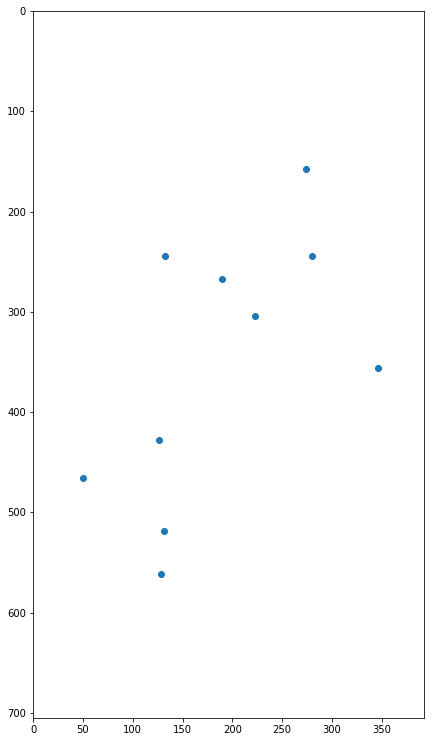

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x048\x00\x00\x07\x80\x08\x02\x00\x00\x00\xa4\x03p]\x…

In [53]:
# load our data (use the Data Builder to generate these files)
planets = pd.read_csv('./planets.csv')
sectors = pd.read_csv('./sectors.csv')

configure_planet_plot()
plot.scatter(planets['X'], planets['Y'])
plot.show()
display_star_system_overlay()

In [54]:
# calculate the pairwise distances between the points (see https://stackoverflow.com/questions/4856090/symmetric-matrices-in-numpy)
def calc_pairwise_distances(x,y, warp_lanes = []):
  size = len(x)
  matrix = [[0] * size for _ in range(size)]
  for from_node in range(size):
    for to_node in range(size):
      if from_node == to_node:
        matrix[from_node][to_node] = 0
      else:
        matrix[from_node][to_node] = math.sqrt((x[from_node] - x[to_node])**2 + (y[from_node] - y[to_node])**2)
  result = np.array(matrix)
  # zero distance between any warp lanes
  for lane in warp_lanes:
    result[lane[0]][lane[1]] = 0 
    result[lane[1]][lane[0]] = 0 
  return result  

planet_pairwise_distances = calc_pairwise_distances(planets['X'], planets['Y'])
planet_pairwise_distances

array([[  0.        ,  86.20904825, 166.01204776, 137.61177275,
        154.65122049, 210.68459839, 307.902582  , 380.84117424,
        388.29112789, 429.5718799 ],
       [ 86.20904825,   0.        , 148.        ,  92.89241088,
         82.75868534, 130.        , 239.94165958, 319.66232183,
        312.77148208, 352.4599268 ],
       [166.01204776, 148.        ,   0.        ,  62.39390996,
        109.        , 241.53674669, 184.0978001 , 236.66009381,
        275.00181818, 318.02515624],
       [137.61177275,  92.89241088,  62.39390996,   0.        ,
         49.57822102, 179.60233851, 173.25414858, 243.31255619,
        258.81460546, 301.44485399],
       [154.65122049,  82.75868534, 109.        ,  49.57822102,
          0.        , 133.5402561 , 157.43252523, 237.00843867,
        233.85679379, 274.93453766],
       [210.68459839, 130.        , 241.53674669, 179.60233851,
        133.5402561 ,   0.        , 231.48218074, 315.77840331,
        269.8036323 , 299.93332592],
       [30

In [55]:
# Use Google OR tools for the TSP solver (https://developers.google.com/optimization/routing/tsp)

# we need a distance callback  takes two arguments, the from and to node indices,
# and returns the distance between these node
class CreateDistanceCallback(object):
  def __init__(self, distances):
    self.matrix = distances

  def Distance(self, from_node, to_node):
    return int(self.matrix[from_node][to_node])

def solve_tsp_with_ortools(pairwise_distances, max_time=5000):
  tsp_size = len(pairwise_distances[0])
  num_routes = 1 # Always 1 for TSP
  depot = 0 # Nodes are indexed from 0 to tsp_size - 1. The depot is the starting node of the route.

  # create routing model
  routing = pywrapcp.RoutingModel(tsp_size, num_routes, depot)
  search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()

  # switch to a guided local search so we can do a little better than the default solver
  search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
  search_parameters.time_limit_ms = max_time

  dist_between_nodes = CreateDistanceCallback(pairwise_distances)
  dist_callback = dist_between_nodes.Distance
  routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)

  # Solve
  assignment = routing.SolveWithParameters(search_parameters)

  total_distance = assignment.ObjectiveValue()
  index = routing.Start(0) # Index of the variable for the starting node.
  best_ortools_path = []
  while not routing.IsEnd(index):
    # Convert variable indices to node indices in the displayed route.
    best_ortools_path += [routing.IndexToNode(index)]  
    index = assignment.Value(routing.NextVar(index))
  return total_distance, best_ortools_path  
    
total_distance, best_ortools_path = solve_tsp_with_ortools(planet_pairwise_distances, 5000)  

print('Total distance: ' + str(total_distance))
list(map(lambda i: planets.iat[i,1], best_ortools_path))

Total distance: 1169


['Ecusana',
 'Admetus',
 'Kongo',
 'Amon',
 'Roxea',
 'Hamelis',
 'Ford',
 'Dedena',
 'Danilama',
 'Arandil']

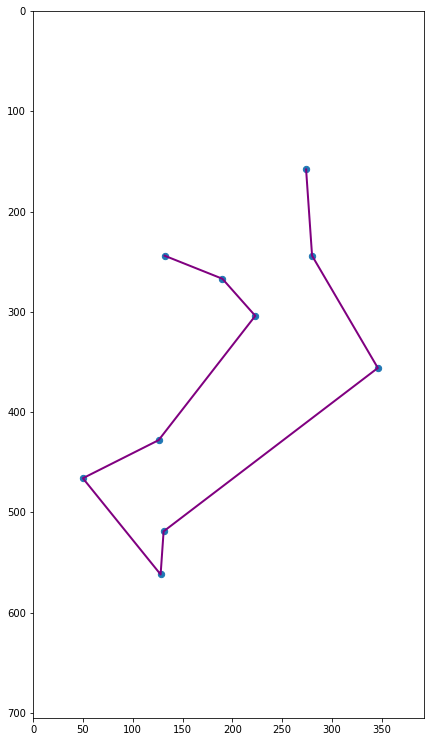

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x048\x00\x00\x07\x80\x08\x02\x00\x00\x00\xa4\x03p]\x…

In [56]:
# Plot it
x = list(map(lambda i: planets.iat[i,2], best_ortools_path))
y = list(map(lambda i: planets.iat[i,3], best_ortools_path))

configure_planet_plot()
plot.plot(x, y, 'purple', lw=2)
plot.scatter(x, y, s=40)
plot.show()
display_star_system_overlay()


In [57]:
# Now on to warp lanes!  Best would be a brute force approach of running TSP for each
# combination of N Choose 3 warp lanes (calculated by setting the pairwise distances for
# the warp-lane connected planets to zero)
# But let's first see how much time this will take...
NUM_WARP_LANES = 3

# 5ms seems really, really low, but I confirmed it made almost no difference to the solution found without warp
# lanes
SOLVER_MAX_TIME_PER_ITERATION = 5 #ms  

num_planets = len(planets['X'])
planet_pairs = itertools.combinations(range(0, num_planets-1), 2)

choose_k_warp_lanes = list(itertools.combinations(planet_pairs,NUM_WARP_LANES))

# before we start, let's estimate the time it will take
num_seconds = len(choose_k_warp_lanes)*SOLVER_MAX_TIME_PER_ITERATION/3/60/60
print("Warp lane calculation will take " + str(num_seconds) + " hours")

Warp lane calculation will take 3.305555555555556 hours


In [58]:
# Gulp, that's *maybe* palatable at three warp lanes, but not very...with four, ouch! And we
# really need to solve the trade stations at the same time, which is 3 choose Possible Points/Sectors.
# Not feasible...

# Another idea - do placements (alternating trade stations and warp lanes) one at a time, landing
# each best placement in sequence, to get a decent solution

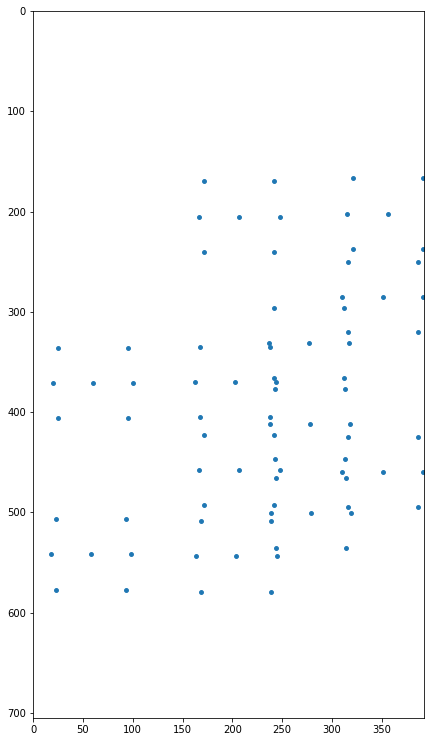

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x048\x00\x00\x07\x80\x08\x02\x00\x00\x00\xa4\x03p]\x…

In [59]:
# Trade station possible points - for each sector hexagon, test each vertex and the center point;
# On the assumption that we have two empty side-by-side sectors that we've marked *somewhere*,
# the hexagon width (side to side) will be the min distance
pairwise_sector_distances = calc_pairwise_distances(sectors['X'],sectors['Y'])
all_distances = list(np.array(pairwise_sector_distances).flat)
all_distances = list(filter(lambda x: x !=0, all_distances))
hex_long_r = min(all_distances) / 2
hex_short_r = math.sqrt(3) * hex_long_r / 2
hex_sine = hex_long_r * math.sin(math.radians(60))

sector_hexagons = []
for index, sector in sectors.iterrows():
    x = sector['X']
    y = sector['Y']
    points = [[x,y]]
    points.append([x+hex_long_r,y])
    points.append([x+hex_sine, y+hex_short_r])
    points.append([x-hex_sine, y+hex_short_r])
    points.append([x-hex_long_r,y])
    points.append([x-hex_sine, y-hex_short_r])
    points.append([x+hex_sine, y-hex_short_r])
    sector_hexagons.append(points)
    
# plot all the possible locations we'll be looking at
configure_planet_plot()
sector_points = np.array([val for sublist in sector_hexagons for val in sublist])
plot.scatter(sector_points[:,0], sector_points[:,1], s=15)
plot.show()
display_star_system_overlay()

In [ ]:
# do the one at a time approach
def add_suboptimal_trade_station(planets_and_stations, warp_lanes, used_hexagon_indexes):
  # initialize a new station
  new_location = {'Name':('Station'+str(len(planets_and_stations['X'])+1)), 'X':0, 'Y':0, 'Unnamed 0':''}
  planets_and_stations.loc[len(planets_and_stations['X'])] = new_location
  size = len(planets_and_stations['X'])
                            
  # try each possible point  
  best_hex = None
  best_point = None                                                    
  best_distance = None
  best_route = None
  for hex_i, hexagon in enumerate(sector_hexagons):
    if hex_i in used_hexagon_indexes:
      continue                                                  
    for point in hexagon:
      planets_and_stations.loc[size-1,'X'] = point[0]
      planets_and_stations.loc[size-1,'Y'] = point[1]
      distances = calc_pairwise_distances(planets_and_stations['X'], planets_and_stations['Y'], warp_lanes)
      total_distance, route = solve_tsp_with_ortools(distances, 100)
      if(best_distance == None or total_distance < best_distance):
        best_distance = total_distance
        best_hex = hex_i
        best_point = point
        best_route = route
  # keep the best point                                                   
  planets_and_stations.at[size-1,'X'] = best_point[0]
  planets_and_stations.at[size-1,'Y'] = best_point[1]
                                                      
  # blacklist the used hexagon
  used_hexagon_indexes.append(best_hex)
  
  print('New station added: ' + str(best_point[0]) + ',' + str(best_point[1]))
  return best_route  
    
def add_suboptimal_warp_lane(planets_and_stations, warp_lanes): 
  size = len(planets_and_stations['X'])
  # initialize a new warp lane
  warp_lanes.append([0,0])
  planet_pairs = itertools.combinations(range(0, size-1), 2)

  best_route = None
  best_distance = None  
  best_warp_lane = None
  for pair in planet_pairs:
    warp_lanes[-1] = pair
    distances = calc_pairwise_distances(planets_and_stations['X'], planets_and_stations['Y'], warp_lanes)
    total_distance, route = solve_tsp_with_ortools(distances, 100)
    if(best_distance == None or total_distance < best_distance):
        best_distance = total_distance
        best_route = route
        best_warp_lane = pair
  warp_lanes[-1] = best_warp_lane
  print('New warp lane added: ' + str(warp_lanes[-1]))
  return best_route

# let's do this
planets_and_stations = planets.copy()
warp_lanes = []
used_hexagon_indexes = []

# three stations, four warp lanes
add_suboptimal_trade_station(planets_and_stations, warp_lanes, used_hexagon_indexes)
add_suboptimal_warp_lane(planets_and_stations, warp_lanes) 
add_suboptimal_trade_station(planets_and_stations, warp_lanes, used_hexagon_indexes)
add_suboptimal_warp_lane(planets_and_stations, warp_lanes) 
add_suboptimal_trade_station(planets_and_stations, warp_lanes, used_hexagon_indexes)
best_route = add_suboptimal_warp_lane(planets_and_stations, warp_lanes) 

best_route         

New station added: 207,205
New warp lane added: (5, 9)
New station added: 312.07670166934173,295.92329833065827
New warp lane added: (0, 7)


In [ ]:
# plot it
route_ordered = [planets_and_stations.loc[i] for i in best_route]
planets = planets_and_stations[:-3]
stations = planets_and_stations[-3:]

configure_planet_plot()
# whole route
plot.plot([p["X"] for p in route_ordered], [p["Y"] for p in route_ordered], 'blue', lw=2)
# plus back to start
plot.plot([route_ordered[0]['X'],route_ordered[-1]['X']], [route_ordered[0]['Y'],route_ordered[-1]['Y']], 'blue', lw=2)
# warp lanes
for planet_pair in warp_lanes:
  planet_a = planets_and_stations.loc[planet_pair[0]]
  planet_b = planets_and_stations.loc[planet_pair[1]] 
  plot.plot([planet_a['X'], planet_b['X']], [planet_a['Y'], planet_b['Y']], 'red', lw=4)
# planets
plot.scatter(planets['X'], planets['Y'], s=30)
# stations
plot.scatter(stations['X'], stations['Y'], s=100)
# sectors
plot.scatter(sector_points[:,0], sector_points[:,1], s=15)

plot.show()
display_star_system_overlay()